Loading 41 files.
Loading 41 files.
Loading 25 files.


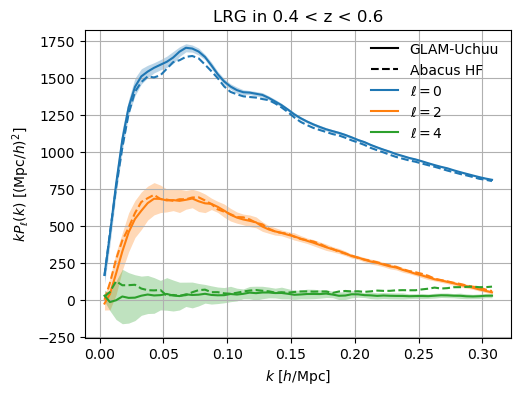

Loading 41 files.
Loading 41 files.
Loading 25 files.


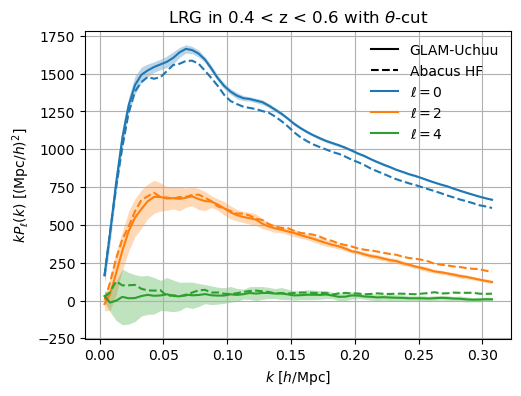

In [1]:
from pathlib import Path
from functools import partial

from matplotlib import pyplot as plt
import numpy as np

from jaxpower import Spectrum2Poles

from uchuu import get_measurement_fn
from abacus_hf import get_measurement_fn as get_abacus_measurement_fn

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

rebin = 5
for tracer in ['BGS', 'LRG1', 'LRG2', 'LRG3'][1:2]:
    for kind in ['mesh2spectrum', 'mesh2spectrum_thetacut']:
        catalog_args = dict(tracer=tracer)
        with_abacus = 'LRG' in tracer
        zsnap, zrange = {'BGS': (None, (0.1, 0.4)), 'LRG1': (0.5, (0.4, 0.6)), 'LRG2': (0.725, (0.6, 0.8)), 'LRG3': (0.950, (0.8, 1.1))}[tracer]
        if with_abacus:
            catalog_abacus_args = dict(tracer=tracer[:3], zsnap=zsnap, zrange=zrange)

        def load(get_fn):
            fns = [[get_fn(imock=imock, region=region, kind=kind) for region in ['NGC', 'SGC']] for imock in range(50)]
            toret = [Spectrum2Poles.load(fn[0]) + Spectrum2Poles.load(fn[1]) for fn in fns if Path(fn[0]).exists()]
            print(f'Loading {len(toret):d} files.')
            return toret

        pk_uchuu = Spectrum2Poles.mean(load(partial(get_measurement_fn, **catalog_args))).slice(slice(0, None, rebin))
        cov_uchuu = Spectrum2Poles.cov(load(partial(get_measurement_fn, **catalog_args))).slice(slice(0, None, rebin))
        if with_abacus:
            pk_abacus = Spectrum2Poles.mean(load(partial(get_abacus_measurement_fn, **catalog_abacus_args))).slice(slice(0, None, rebin))
        
        fig, ax = plt.subplots(figsize=(5.5, 4))
        title = f'{tracer[:3]} in {zrange[0]:.1f} < z < {zrange[1]:.1f}'
        if 'thetacut' in kind: title += rf' with $\theta$-cut'
        ax.set_title(title)
        ax.plot([], [], color='k', linestyle='-', label='GLAM-Uchuu')
        if with_abacus:
            ax.plot([], [], color='k', linestyle='--', label='Abacus HF')
        for ill, ell in enumerate(pk_uchuu.projs):
            color = 'C{:d}'.format(ill)
            k = pk_uchuu.x(projs=ell)
            ax.plot(k, k * pk_uchuu.view(projs=ell).real, color=color, linestyle='-', label=f'$\ell = {ell:d}$')
            std = cov_uchuu.select(projs=ell, select_projs=True).std()
            ax.fill_between(k, k * (pk_uchuu.view(projs=ell).real - std),
                            k * (pk_uchuu.view(projs=ell).real + std),
                            color=color, alpha=0.3, linewidth=0.)
            if with_abacus:
                ax.plot(k, k * pk_abacus.view(projs=ell).real, color=color, linestyle='--')

        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.legend(frameon=False)
        ax.grid(True)
        basename = f'spectrum_GLAM-Uchuu_{tracer}'
        if 'thetacut' in kind: basename += '_thetacut'
        fig.savefig(plot_dir / (basename + '.png'), bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

Loading 4 files.
Loading 4 files.
Loading 5 files.


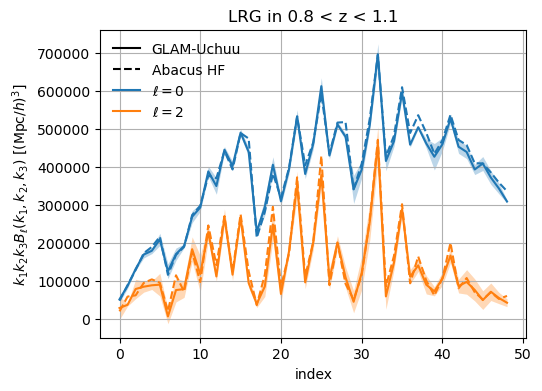

In [2]:
from jaxpower import Spectrum3Poles

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

rebin = 5
for tracer in ['BGS', 'LRG1', 'LRG2', 'LRG3'][-1:]:
    for kind in ['mesh3spectrum_scoccimarro']:
        catalog_args = dict(tracer=tracer)
        with_abacus = 'LRG' in tracer
        zsnap, zrange = {'BGS': (None, (0.1, 0.4)), 'LRG1': (0.5, (0.4, 0.6)), 'LRG2': (0.725, (0.6, 0.8)), 'LRG3': (0.950, (0.8, 1.1))}[tracer]
        if with_abacus:
            catalog_abacus_args = dict(tracer=tracer[:3], zsnap=zsnap, zrange=zrange)

        def load(get_fn):
            #fns = [[get_fn(imock=imock, region=region, kind=kind) for region in ['NGC', 'SGC']] for imock in range(50)]
            #toret = [Spectrum3Poles.load(fn[0]) + Spectrum3Poles.load(fn[1]) for fn in fns if Path(fn[0]).exists()]
            fns = [get_fn(imock=imock, region='NGC', kind=kind) for imock in range(5)]
            toret = [Spectrum3Poles.load(fn) for fn in fns if Path(fn).exists()]
            print(f'Loading {len(toret):d} files.')
            return toret

        pk_uchuu = Spectrum3Poles.mean(load(partial(get_measurement_fn, **catalog_args)))
        cov_uchuu = Spectrum3Poles.cov(load(partial(get_measurement_fn, **catalog_args)))
        if with_abacus:
            pk_abacus = Spectrum3Poles.mean(load(partial(get_abacus_measurement_fn, **catalog_abacus_args)))

        fig, ax = plt.subplots(figsize=(5.5, 4))
        title = f'{tracer[:3]} in {zrange[0]:.1f} < z < {zrange[1]:.1f}'
        if 'thetacut' in kind: title += rf' with $\theta$-cut'
        ax.set_title(title)
        ax.plot([], [], color='k', linestyle='-', label='GLAM-Uchuu')
        if with_abacus:
            ax.plot([], [], color='k', linestyle='--', label='Abacus HF')
        for ill, ell in enumerate(pk_uchuu.projs):
            color = 'C{:d}'.format(ill)
            x = np.prod(pk_uchuu.xavg(projs=ell, method='mid'), axis=-1)
            ax.plot(x[1:] * pk_uchuu.view(projs=ell).real[1:], color=color, linestyle='-', label=f'$\ell = {ell:d}$')
            std = cov_uchuu.select(projs=ell, select_projs=True).std()
            ax.fill_between(np.arange(len(x) - 1), x[1:] * (pk_uchuu.view(projs=ell).real[1:] - std[1:]),
                            x[1:] * (pk_uchuu.view(projs=ell).real[1:] + std[1:]),
                            color=color, alpha=0.3, linewidth=0.)
            if with_abacus:
                x = np.prod(pk_abacus.xavg(projs=ell, method='mid'), axis=-1)
                ax.plot(x[1:] * pk_abacus.view(projs=ell).real[1:], color=color, linestyle='--')

        ax.set_xlabel(r'index')
        ax.set_ylabel(r'$k_1 k_2 k_3 B_{\ell}(k_1, k_2, k_3)$ [$(\mathrm{Mpc}/h)^{3}$]')
        ax.legend(frameon=False)
        ax.grid(True)
        basename = f'bispectrum_GLAM-Uchuu_{tracer}'
        if 'thetacut' in kind: basename += '_thetacut'
        fig.savefig(plot_dir / (basename + '.png'), bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()